In [1]:
import os

# Example: Set path to your dataset folder
data_dir = r"D:\Brain-Tumor-Detection-main\data"

# List the files to confirm
print("Files in dataset folder:", os.listdir(data_dir))


Files in dataset folder: ['MRI IMAGES']


In [2]:
!pip install tensorflow


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Program Files\Python39\python.exe -m pip install --upgrade pip


In [4]:
pip install tensorflow==2.16.1


^C
Note: you may need to restart the kernel to use updated packages.


In [5]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.20.0


In [ ]:
import sys
print(sys.executable)


d:\anaconda\python.exe


In [ ]:
pip show tensorflow


Note: you may need to restart the kernel to use updated packages.


In [8]:
!pip install scikit-learn


In [7]:
!pip install matplotlib


# Imports Libraries and Tools

In [4]:
import os  # For directory and file operations
import numpy as np  # For numerical operations and handling image arrays
import random  # For generating random values for augmentation
from PIL import Image, ImageEnhance  # For image processing and enhancement
from tensorflow.keras.preprocessing.image import load_img  # For loading images
from tensorflow.keras.models import Sequential  # For building the model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense  # For model layers
from tensorflow.keras.optimizers import Adam  # For optimizer
from tensorflow.keras.applications import VGG16  # For using VGG16 model
from sklearn.utils import shuffle  # For shuffling the data

# Load Datasets

In [10]:
# Directories for training and testing data
# Local dataset paths (use raw string r"" for Windows paths)
train_dir = r"D:\Brain-Tumor-Detection-main\data\MRI IMAGES\Training"
test_dir  = r"D:\Brain-Tumor-Detection-main\data\MRI IMAGES\Testing"

# Load and shuffle the train data
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle the test data
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

# Data Visualization

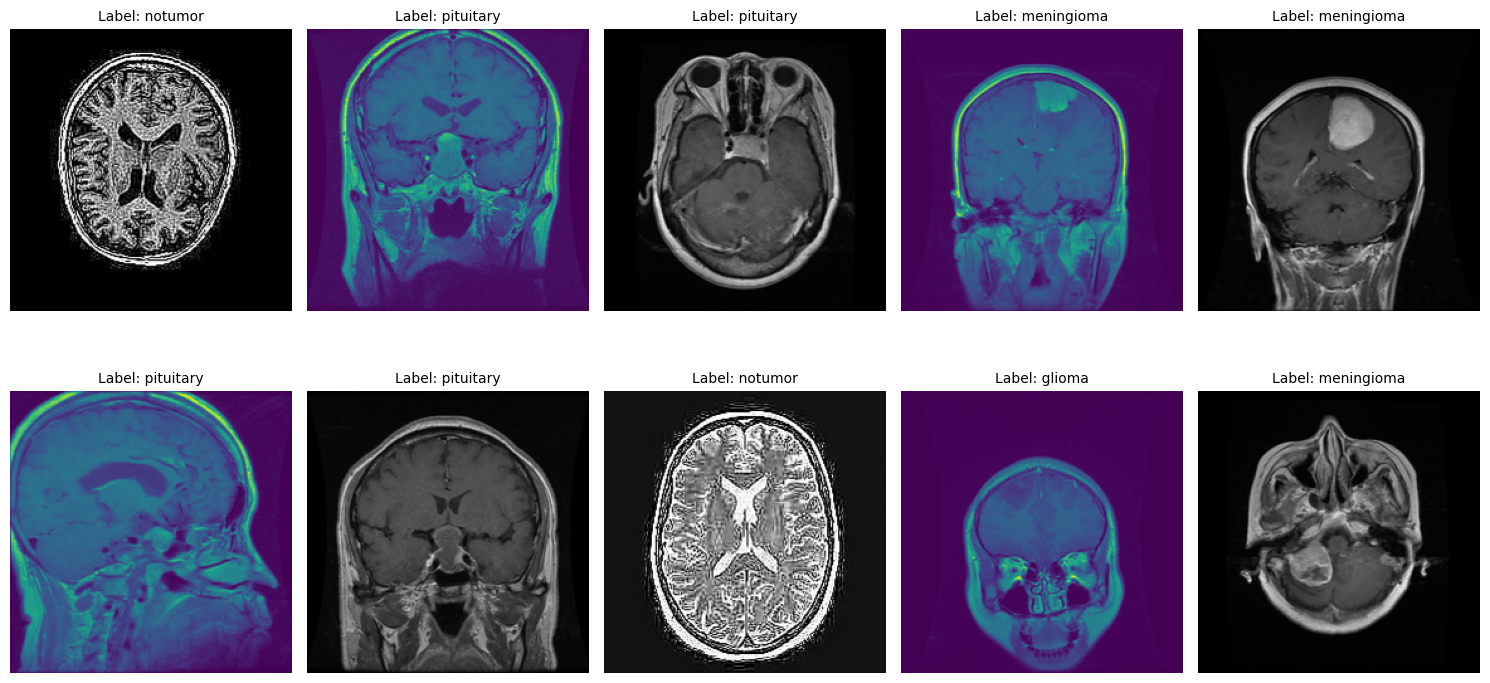

In [11]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Load image
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to consistent size

    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axis
    # Display class label in the second row
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()


# Image Preprocessing (Helper Functions)

In [5]:

import os
import random
from collections import Counter

import numpy as np
from PIL import Image, ImageEnhance
import cv2

IMAGE_SIZE = 128
DEFAULT_DENOISE_METHOD = 'median' 
SEED=42
random.seed(SEED)
np.random.seed(SEED)


def preprocess_image_path(path,
                          image_size=IMAGE_SIZE,
                          augment=False,
                          denoise=False,
                          denoise_method=DEFAULT_DENOISE_METHOD,
                          keep_uint8=False):
  
    try:
        img = Image.open(path).convert('RGB')
        img = img.resize((image_size, image_size), resample=Image.BILINEAR)
        arr = np.array(img)
    except Exception as e:
        print(f"[WARN] Could not read {path}: {e}")
        arr = np.zeros((image_size, image_size, 3), dtype=np.uint8)

    if denoise and denoise_method:
        try:
            if denoise_method == 'median':
                arr = cv2.medianBlur(arr, 5)
            elif denoise_method == 'gaussian':
                arr = cv2.GaussianBlur(arr, (5, 5), 0)
            elif denoise_method == 'bilateral':
                arr = cv2.bilateralFilter(arr, d=9, sigmaColor=75, sigmaSpace=75)
        except Exception:
            pass

    if augment:
        pil = Image.fromarray(arr)
        pil = ImageEnhance.Brightness(pil).enhance(random.uniform(0.85, 1.15))
        pil = ImageEnhance.Contrast(pil).enhance(random.uniform(0.85, 1.15))
        angle = random.uniform(-12, 12)
        pil = pil.rotate(angle, resample=Image.BILINEAR, fillcolor=(0, 0, 0))
        if random.random() < 0.5:
            pil = pil.transpose(Image.FLIP_LEFT_RIGHT)
        if random.random() < 0.3:
            w, h = pil.size
            zx = random.uniform(0.92, 1.0)
            new_w, new_h = int(w * zx), int(h * zx)
            left = (w - new_w) // 2
            top = (h - new_h) // 2
            pil = pil.crop((left, top, left + new_w, top + new_h)).resize((w, h), Image.BILINEAR)
        arr = np.array(pil)

    if keep_uint8:
        return arr

    return arr.astype('float32') / 255.0


def open_images(paths, augment=False, denoise=False, denoise_method=DEFAULT_DENOISE_METHOD, verbose=False):
   
    images = []
    for p in paths:
        try:
            im = preprocess_image_path(p, IMAGE_SIZE, augment=augment, denoise=denoise, denoise_method=denoise_method)
            images.append(im)
        except Exception as e:
            if verbose:
                print(f"[WARN] failed to process {p}: {e}")
    if len(images) == 0:
        return np.zeros((0, IMAGE_SIZE, IMAGE_SIZE, 3), dtype='float32')
    return np.stack(images, axis=0)


def encode_labels(labels, class_names=None):
    
    if class_names is None:
        class_names = sorted(list(set(labels)))
    mapping = {c: i for i, c in enumerate(class_names)}
    return np.array([mapping[l] for l in labels])


def datagen(paths, labels, batch_size=32, denoise=False, denoise_method=DEFAULT_DENOISE_METHOD,epochs=1):
   
    n = len(paths)
    idxs = np.arange(n)
    while True:
        np.random.shuffle(idxs)
        for i in range(0, n, batch_size):
            batch_idx = idxs[i:i + batch_size]
            batch_paths = [paths[j] for j in batch_idx]
            batch_labels = [labels[j] for j in batch_idx]
            batch_x = open_images(batch_paths, augment=True, denoise=denoise, denoise_method=denoise_method)
            batch_y = encode_labels(batch_labels, class_names=sorted(list(set(labels))))
            yield batch_x, batch_y



def show_before_after(path, denoise=False, denoise_method=DEFAULT_DENOISE_METHOD):
    import matplotlib.pyplot as plt
    raw = Image.open(path).convert('RGB').resize((IMAGE_SIZE, IMAGE_SIZE))
    proc = preprocess_image_path(path, IMAGE_SIZE, augment=False, denoise=denoise, denoise_method=denoise_method)
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1); plt.imshow(raw); plt.title('Raw'); plt.axis('off')
    plt.subplot(1, 2, 2); plt.imshow(proc); plt.title('Preprocessed'); plt.axis('off')
    plt.show()


def dataset_summary(train_paths, train_labels, test_paths=None, test_labels=None):
    """Prints quick counts and distributions for train/test sets."""
    print("Train count:", len(train_paths))
    print(Counter(train_labels))
    if test_paths is not None and test_labels is not None:
        print("Test count:", len(test_paths))
        print(Counter(test_labels))


if __name__ == '__main__':
    print('preprocess.py loaded.')



preprocess.py loaded.


# MODEL:

## WE ARE USING VGG16 FOR TRANSFER LEARNING.

 The model is built on top of VGG16, which is a pre-trained convolutional neural network (CNN) for image classification.

* First, the VGG16 model is loaded with input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet'. The input shape is set to match the size of the images in the dataset, which is 128x128 pixels. The include_top parameter is set to False, which means that the final fully-connected layers of VGG16 that perform the classification will not be included. The weights parameter is set to 'imagenet' which means that the model will be pre-trained with a dataset of 1.4 million images called imagenet

* Next, the for layer in base_model.layers: loop is used to set all layers of the base_model (VGG16) to non-trainable, so that the weights of these layers will not be updated during training.

* Then, the last three layers of the VGG16 model are set to trainable by using base_model.layers[-2].trainable = True,base_model.layers[-3].trainable = True and base_model.layers[-4].trainable = True

* After that, a Sequential model is created and the VGG16 model is added to it with model.add(base_model).

* Next, a Flatten layer is added to the model with model.add(Flatten()) which reshapes the output of the VGG16 model from a 3D tensor to a 1D tensor, so that it can be processed by the next layers of the model.

* Then, a Dropout layer is added with model.add(Dropout(0.3)) which is used to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training time.

* After that, a dense layer is added with 128 neurons and relu activation function is added with model.add(Dense(128, activation='relu')).

* Next, another Dropout layer is added with model.add(Dropout(0.2))

* Finally, the output dense layer is added with number of neurons equal to the number of unique labels and 'softmax' activation function is added with model.add(Dense(len(unique_labels), activation='softmax')). The 'softmax' activation function is used to give a probability distribution over the possible classes.




In [6]:
# Model architecture
IMAGE_SIZE = 128  # Image size (adjust based on your requirements)
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)  # Add VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 5

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

NameError: name 'train_dir' is not defined

# Train and Val Plots

# Model Classification Report

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))


41/41 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.80      0.88       300
           1       0.84      0.88      0.86       306
           2       0.93      1.00      0.96       405
           3       0.96      0.97      0.97       300

    accuracy                           0.92      1311
   macro avg       0.92      0.91      0.92      1311
weighted avg       0.92      0.92      0.92      1311



# Model Confusion Plot

Confusion Matrix:
[[241  49  10   0]
 [  5 269  19  13]
 [  0   0 405   0]
 [  3   3   2 292]]


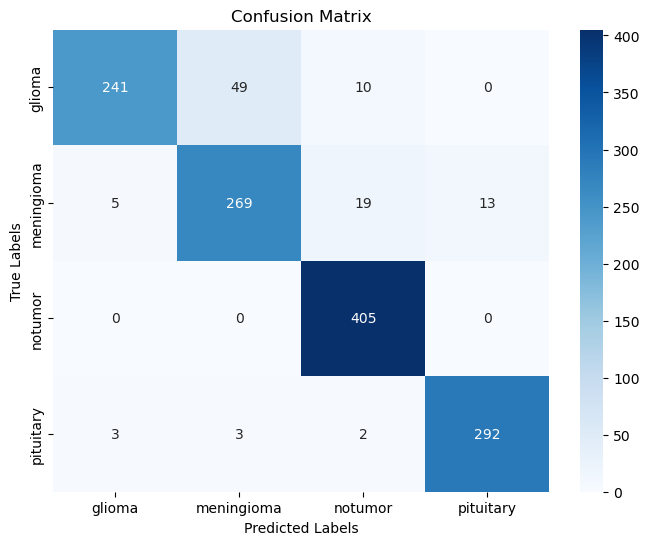

In [ ]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Roc Curve Plot


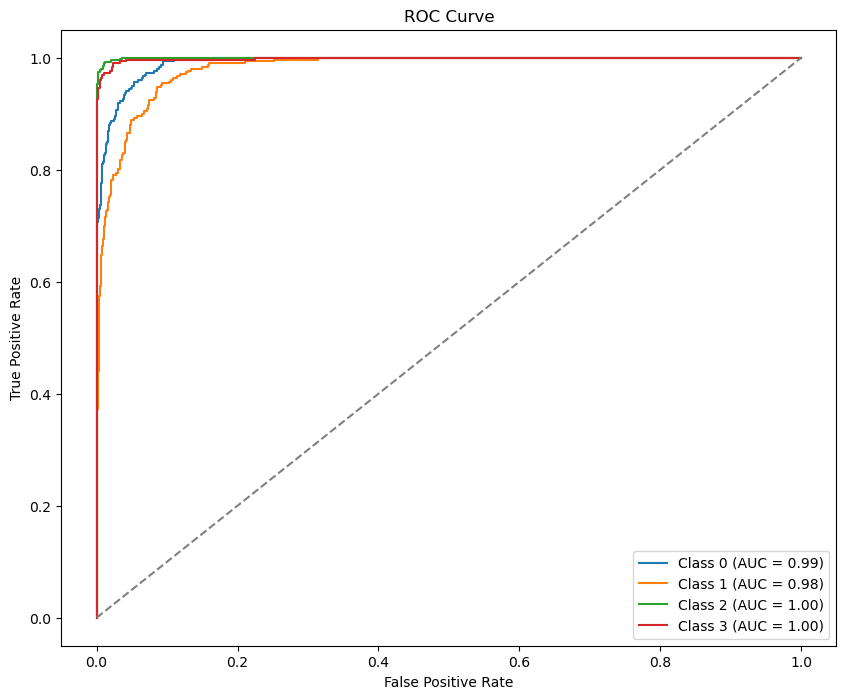

In [ ]:
# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Save & Load Model

In [ ]:
# Save the entire model
model.save('model.h5')

In [ ]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('model.h5')

# MRI Tumor Detection System

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))


In [ ]:
# Example usage
image_path = 'Te-meTr_0001.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

NameError: name 'detect_and_display' is not defined

In [ ]:

# Example usage
image_path = '/content/drive/MyDrive/MRI Images/Testing/notumor/Te-noTr_0004.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

Error processing the image: [Errno 2] No such file or directory: '/content/drive/MyDrive/MRI Images/Testing/notumor/Te-noTr_0004.jpg'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


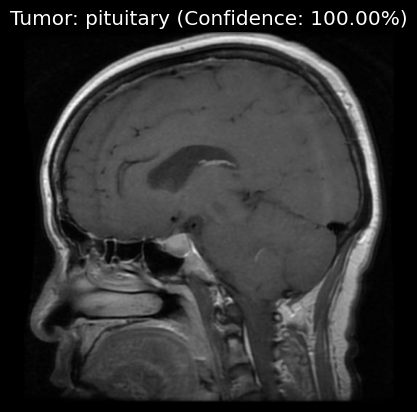

In [ ]:
# Example usage
image_path = '/content/drive/MyDrive/MRI Images/Testing/pituitary/Te-piTr_0003.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


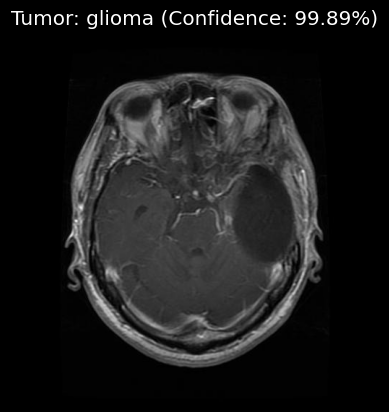

In [ ]:
# Example usage
image_path = '/content/drive/MyDrive/MRI Images/Testing/glioma/Te-gl_0015.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)